In [1]:
from __future__ import print_function, division
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import urllib.request
import requests
import json
from io import StringIO
import io
import shapely
import pysal as ps
from fiona.crs import from_epsg

In [2]:
#matplotlib.style.use('dark_background')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

In [3]:
urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', "file.gz")

('file.gz', <http.client.HTTPMessage at 0x10db04438>)

In [4]:
os.system("mv " + "file.gz " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/file.gz -d " + os.getenv("PUIDATA") + "/puma")
pumashp = gpd.read_file(os.getenv("PUIDATA") + "/puma" + "/geo_export_c1ff3a09-7b6d-4ae0-9712-b7ab86c90c6a.shp")
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [5]:
pumashp.crs

{'init': 'epsg:4326'}

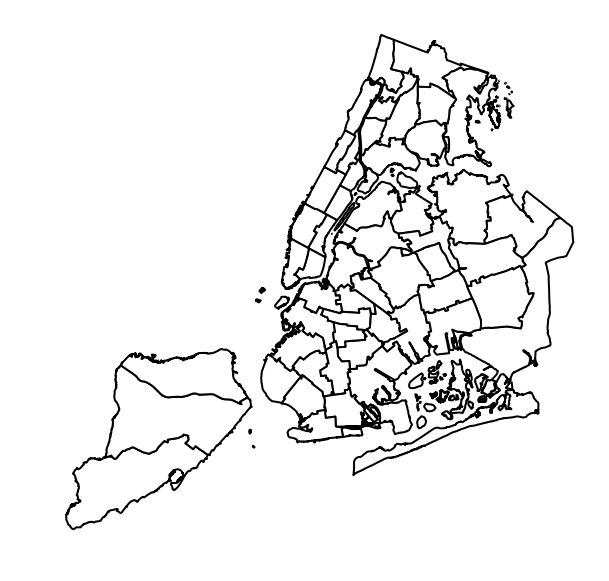

Figure 1. Outline of puma shapefile


In [6]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2)
plt.show()
print ('Figure 1. Outline of puma shapefile')

In [7]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

In [8]:
myAPI

'00a258b62929a06b7c5cb943ed9dd74f2baca864'

In [9]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [10]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

In [11]:
affkeys.shape

(125864,)

In [12]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subs

In [13]:
#keyword for the number of households
keyNhouseholds = "B28002_001E"
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [14]:
#keyword for the number of households with broarband access
keyNBB = "B28002_004E"
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [15]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [16]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [17]:
pumaPP.head(1)

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN


In [18]:
formerge = pumaPP[['B28002_001E', 'public use microdata area']]
formerge.head(1)

,B28002_001E,public use microdata area
0,40479,100


In [19]:
pumaBB = pd.merge(pumaBB, formerge, on='public use microdata area').drop_duplicates()

In [20]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146


In [21]:
pumaBB['pcBB'] = pumaBB.B28002_004E / pumaBB.B28002_001E * 100
pumaBB.drop(columns=['Unnamed: 4'], axis=1, inplace=True)
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


### 2.3 Now compare it with the AFF published "percentage of households with broadband access"

In [22]:
os.system("unzip " + os.getenv("PUIDATA") + "/aff_download.zip -d " + os.getenv("PUIDATA"))

256

In [23]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   header=1,
                   usecols=["Target Geo Id2","Percent","Margin of Error"])
bbpc.head()

,Target Geo Id2,Percent,Margin of Error
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [24]:
bbpc['Target Geo Id2'] = bbpc['Target Geo Id2'].astype(str)

In [25]:
bbpc.shape

(2430, 3)

In [26]:
iddict = {}
for i, geoid in enumerate(bbpc['Target Geo Id2']):   
    if len(geoid) < 7:
        bbpc.drop(i, inplace=True)
    elif geoid[:2] != '36':
        bbpc.drop(i, inplace=True)
    else:
        iddict[geoid] = geoid[-4:]

In [27]:
iddf = pd.DataFrame.from_dict(iddict, orient='index', dtype=int)

In [28]:
iddf.reset_index(level=0, inplace=True)
iddf.columns = ['Target Geo Id2', 'public use microdata area']
iddf.head()

,Target Geo Id2,public use microdata area
0,3600100,100
1,3600200,200
2,3600300,300
3,3600401,401
4,3600402,402


In [29]:
bbpc = pd.merge(bbpc, iddf, on='Target Geo Id2').drop_duplicates('Target Geo Id2')

In [30]:
bbpc.head()

,Target Geo Id2,Percent,Margin of Error,public use microdata area
0,3600100,80.6,2.6,100
1,3600200,75.7,2.2,200
2,3600300,79.8,2.6,300
3,3600401,81.4,2.4,401
4,3600402,78.2,2.3,402


In [31]:
diff_ = pd.merge(pumaBB, bbpc, on="public use microdata area")[["pcBB", "Percent"]]
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["Percent"].astype(float))
diff_.describe()

,pcBB,Percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


In [32]:
diff_.dtypes

pcBB       float64
Percent    float64
diff       float64
dtype: object

### 3 Plot a choropleth of NYC broadband access

In [33]:
pumashp.dtypes

puma           object
shape_leng    float64
shape_area    float64
geometry       object
dtype: object

In [34]:
pumaBB.dtypes

B28002_004E                    int64
NAME                          object
state                          int64
public use microdata area      int64
B28002_001E                    int64
pcBB                         float64
dtype: object

In [35]:
#choropleth of the percentage of internet axcess
pumaBB['public use microdata area'] = pumaBB['public use microdata area'].astype(str)
pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')
pumashp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


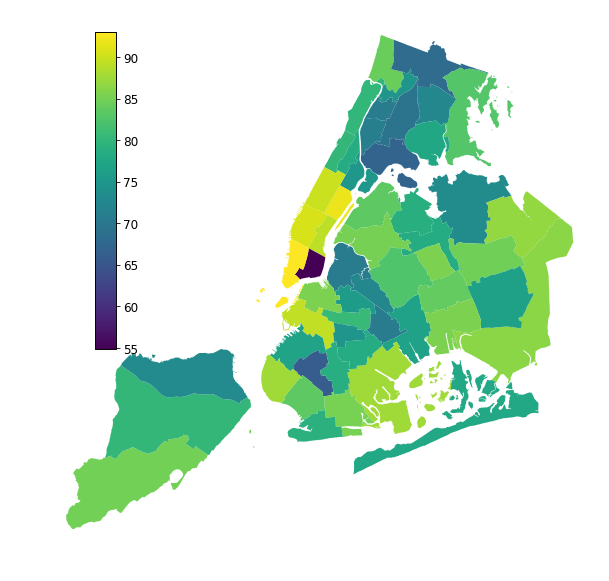

Figure 2. Choropleth of the percentage of households of New York with broadband access in 2016. Lower Manhattan exhibted highly diversity.


In [36]:
cp.choroplethNYC(pumashp, column='pcBB')
plt.show()
print ('Figure 2. Choropleth of the percentage of households of ' +
       'New York with broadband access in 2016. Lower Manhattan ' +
       'exhibted highly diversity.')

### 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [37]:
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv', index_col=0)

In [38]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [39]:
linkNYC.shape

(1414, 4)

In [40]:
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude, linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.94223923850001, 40.701930343899996)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [41]:
linkNYC = gpd.GeoDataFrame(linkNYC)

### plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

In [42]:
linkNYC['date_link_'] = pd.to_datetime(linkNYC['date_link_'], format='%Y/%m/%d')
now = pd.to_datetime('2017-11-23', format='%Y/%m/%d')

In [43]:
linkNYC['timerange'] = now - linkNYC['date_link_']
linkNYC['timerange'] = linkNYC['timerange'].dt.days

In [44]:
linkNYC.drop(['latitude', 'longitude', 'lonlat', 'date_link_'], axis=1, inplace=True)
linkNYC.head()

,link_site,geometry,timerange
0,bk-01-138951,POINT (-73.94248859 40.70166753),145
1,bk-01-109091,POINT (-73.9421692831 40.7015421938),145
2,bk-01-143982,POINT (-73.94223923850001 40.7019303439),145
3,bk-01-109262,POINT (-73.94291758 40.70506042),209
4,bk-01-125268,POINT (-73.953439 40.728133),237


In [45]:
bbshp = pumashp[['geometry', 'pcBB']]
bbshp.head()

,geometry,pcBB
0,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820
1,POLYGON ((-73.86477258283533 40.90201244187379...,68.310015
2,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141
3,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737
4,POLYGON ((-73.87045508990893 40.86663286876232...,69.425612


In [46]:
bbshp.shape

(55, 2)

In [47]:
np.linspace(min(bbshp.pcBB), max(bbshp.pcBB), 6, retstep=True)

(array([ 54.93294453,  62.5524857 ,  70.17202688,  77.79156805,
         85.41110923,  93.0306504 ]), 7.6195411740047136)

In [48]:
bins = pd.cut(bbshp.pcBB, 5, right=False, labels=None, retbins=True, precision=2, include_lowest=True)
bins[0][0]

Interval(77.790000000000006, 85.409999999999997, closed='left')

In [49]:
'{:.2f} - {:.2f}'.format(bins[0][0].left, bins[0][0].right)

'77.79 - 85.41'

In [50]:
df = pd.DataFrame(columns=['pcBBrange'])
for i in range(len(bins[0])):
    pcBBrange = '{:.2f} - {:.2f}'.format(bins[0][i].left, bins[0][i].right)
    df = df.append({'pcBBrange': pcBBrange}, ignore_index=True)
df.shape

(55, 1)

In [51]:
mapdf = pd.concat([bbshp, df], axis=1)
mapdf.head()

,geometry,pcBB,pcBBrange
0,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820,77.79 - 85.41
1,POLYGON ((-73.86477258283533 40.90201244187379...,68.310015,62.55 - 70.17
2,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141,77.79 - 85.41
3,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737,70.17 - 77.79
4,POLYGON ((-73.87045508990893 40.86663286876232...,69.425612,62.55 - 70.17


In [52]:
type(mapdf.pcBBrange[0])

str

In [53]:
type(linkNYC.geometry)

geopandas.geoseries.GeoSeries

In [54]:
linkNYC.crs = from_epsg(4326)

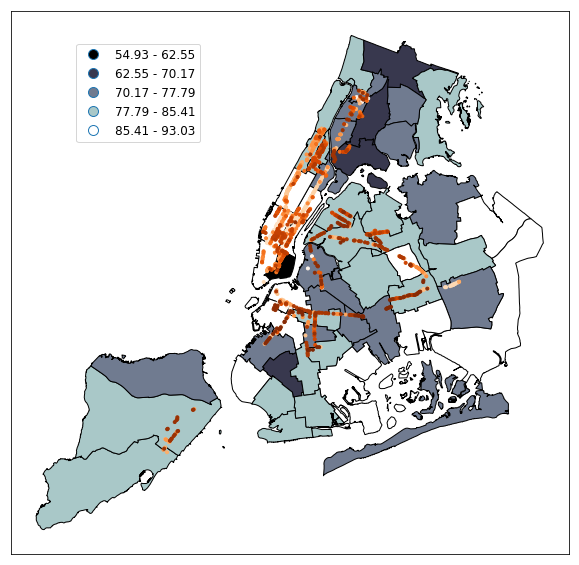

Figure 3. 


In [55]:
f, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=1, ax=ax)
ax = mapdf.plot(column='pcBB', cmap='bone', alpha=1, edgecolor="black", linewidth=1,
           ax=ax, scheme="Equal_interval", legend=True, k=5)
linkNYC.plot(ax=ax, marker='.', c=linkNYC.timerange, cmap='Oranges')
plt.legend(loc=2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.show()
print ('Figure 3. ')

### 5 Find the number of linkNYC locations per person by PUMA

In [56]:
#keyword for the total population
keyTpopu = "B00001_001E"
aff1y['variables'][keyTpopu]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [57]:
# getting the total population
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyTpopu +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumapopu = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumapopu.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [58]:
type(pumapopu)

pandas.core.frame.DataFrame

In [59]:
pumapopu = gpd.GeoDataFrame(pumapopu)
pumapopu.crs = from_epsg(4326)

In [60]:
site = linkNYC[['link_site', 'geometry']]
pumaarea = pumashp[['puma', 'geometry']]

In [61]:
site = site.to_crs(epsg=2263)
pumaarea = pumaarea.to_crs(epsg=2263)

In [62]:
linkpp = gpd.sjoin(
    site, pumaarea, how='left', op='within')[['puma', 'link_site']].groupby('puma').count()
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [63]:
linkpp.reset_index(inplace=True)
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [64]:
pumapopu['public use microdata area'] = pumapopu['public use microdata area'].astype(str)

In [65]:
pumashplc = linkpp.merge(pumapopu, left_on='puma', right_on='public use microdata area', how='outer')

In [66]:
linkpp.dtypes

puma         object
link_site     int64
dtype: object

In [67]:
pumapopu.dtypes

B00001_001E                    int64
NAME                          object
state                          int64
public use microdata area     object
Unnamed: 4                   float64
dtype: object

In [68]:
pumashplc.head()

,puma,link_site,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3705,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN
2,3706,20.0,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN
3,3707,29.0,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN
4,3708,19.0,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN


In [69]:
pumashplc['linkNYCp100p'] = pumashplc['link_site'] / pumashplc['B00001_001E'] * 100
pumashplc.head()

,puma,link_site,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,linkNYCp100p
0,3701,1.0,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,0.065920
1,3705,1.0,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,0.049727
2,3706,20.0,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,1.569859
3,3707,29.0,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN,1.873385
4,3708,19.0,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN,1.299590


In [70]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

In [71]:
linkNYC = linkNYC.to_crs(epsg=2263)

In [72]:
pumashplc.dtypes

puma                          object
link_site                    float64
B00001_001E                    int64
NAME                          object
state                          int64
public use microdata area     object
Unnamed: 4                   float64
linkNYCp100p                 float64
dtype: object

In [73]:
pumashplc = pumashplc.merge(pumashp, left_on='puma', 
                            right_on='puma', how='right')[['puma', 'linkNYCp100p', 'geometry']]
pumashplc.head()

,puma,linkNYCp100p,geometry
0,3701,0.065920,POLYGON ((-73.89641133483133 40.90450452082026...
1,3705,0.049727,POLYGON ((-73.87045508990893 40.86663286876232...
2,3706,1.569859,POLYGON ((-73.91328437051338 40.85961860183316...
3,3707,1.873385,POLYGON ((-73.91328437051338 40.85961860183316...
4,3708,1.299590,"POLYGON ((-73.92478318783078 40.8447526648105,..."


In [74]:
pumashplc = gpd.GeoDataFrame(pumashplc)
pumashplc.crs = from_epsg(4326)
pumashplc = pumashplc.to_crs(epsg=2263)
pumashplc.crs

{'init': 'epsg:2263', 'no_defs': True}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


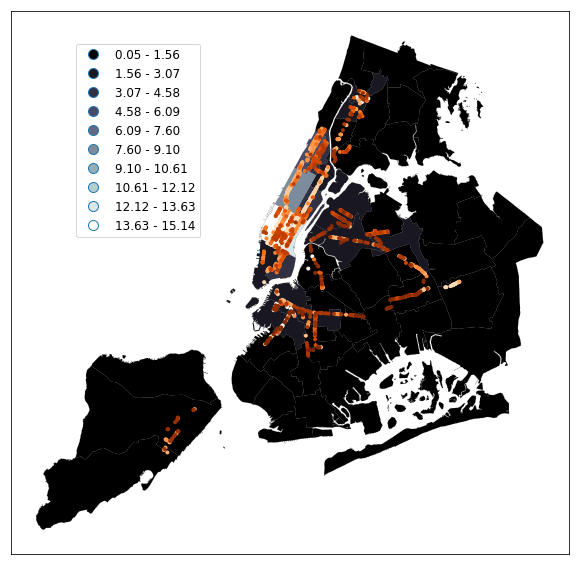

Figure 4. 


In [75]:
#linkNYC = linkNYC.to_crs(world.crs)
f, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#cp.choroplethNYC(pumashp, column=None, color="white", 
#                 edgecolor="black", lw=1, ax=ax)
ax = pumashplc.plot(column='linkNYCp100p', cmap='bone', alpha=1, 
                    edgecolor="black", linewidth=0.1, ax=ax, 
                    scheme="Equal_interval", legend=True, k=10)
linkNYC.plot(ax=ax, marker='.', c=linkNYC.timerange, cmap='Oranges')
plt.legend(loc=2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.show()
print ('Figure 4. ')

### Extra credit 1:

In [76]:
#pumashplc.dropna(inplace=True)
pumashplc.replace(np.nan, 0, inplace=True)
len(pumashplc["linkNYCp100p"])

55

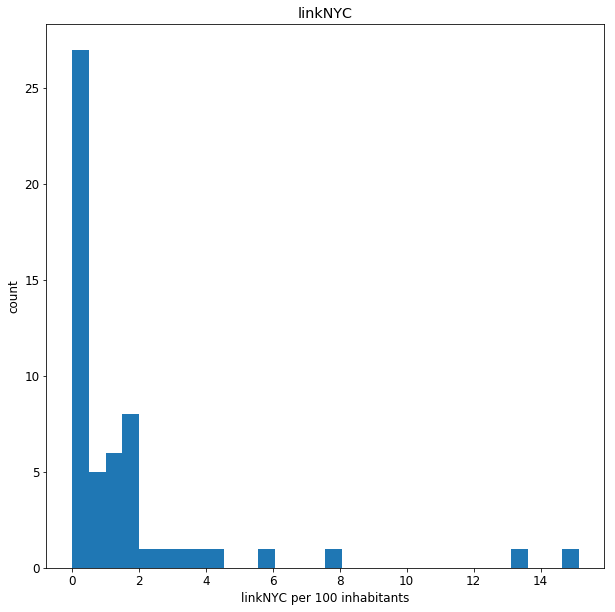

Figure 5. 


In [77]:
plt.hist(pumashplc["linkNYCp100p"], bins=30)
plt.xlabel('linkNYC per 100 inhabitants')
plt.ylabel('count')
plt.title('linkNYC')
plt.show()
print ('Figure 5. ')

In [78]:
pumashp.crs = from_epsg(4326)
pumashp = pumashp.to_crs(epsg=2263)

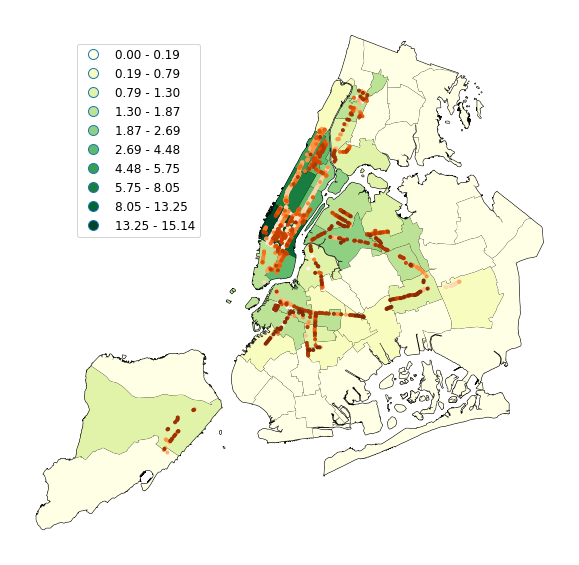

Figure 6. 


In [79]:
#linkNYC = linkNYC.to_crs(world.crs)
f, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cp.choroplethNYC(pumashp, column=None, color="white", 
                 edgecolor="black", lw=1, ax=ax)
ax = pumashplc.plot(column='linkNYCp100p', cmap='YlGn', alpha=1, 
                    edgecolor="black", linewidth=0.1, ax=ax, 
                    scheme="fisher_jenks", legend=True, k=10)
linkNYC.plot(ax=ax, marker='.', c=linkNYC.timerange, cmap='Oranges')
plt.legend(loc=2)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.show()
print ('Figure 6. ')

### Extra Credit 2:

In [80]:
path='pumashplc.shp'
pumashplc.to_file(path)

In [81]:
qW_CT=ps.queen_from_shapefile(path)

In [82]:
qW_CT[10]

{9: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}

In [83]:
qW_CT.cardinalities[10]

4

In [84]:
Wmatrix, ids = qW_CT.full()

In [85]:
Wmatrix

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [86]:
qW_CT.transform = 'r'

In [87]:
impact=pumashplc.linkNYCp100p
impactLag=ps.lag_spatial(qW_CT, impact)

In [88]:
impactLagQ5 = ps.Quantiles(impactLag, k=5)
impactLagQ5

              Quantiles               
 
Lower          Upper             Count
        x[i] <= 0.211               11
0.211 < x[i] <= 0.578               11
0.578 < x[i] <= 0.989               11
0.989 < x[i] <= 2.997               11
2.997 < x[i] <= 9.704               11

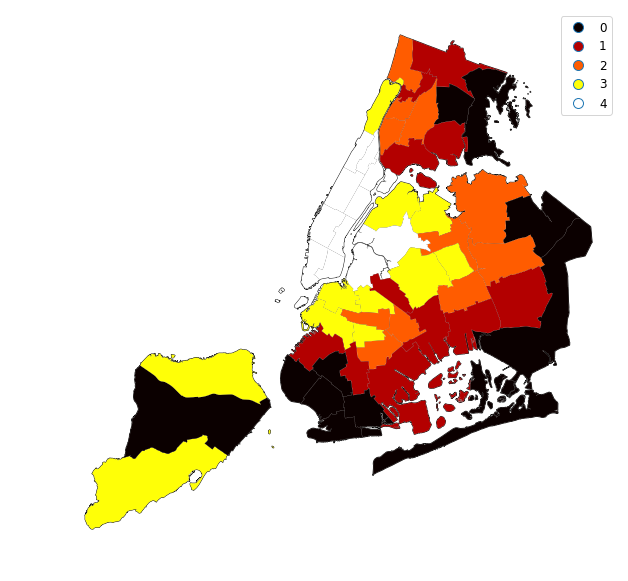

Figure 7. 


In [89]:
f, ax = plt.subplots()
cp.choroplethNYC(pumashp, column=None, color="white", 
                 edgecolor="black", lw=1, ax=ax)
pumashplc.assign(cl=impactLagQ5.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()
print ('Figure 7. ')